In [1]:
import csv
import sys
import json
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, SGDClassifier
from sklearn.ensemble.forest import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, chi2, f_classif
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, SelectFromModel

%matplotlib inline

In [2]:
np.random.seed(42)

In [3]:
df = pd.read_csv('cleaned_games_dataset.csv', index_col='Unnamed: 0')

In [4]:
df.head()

,fg_1_1,fga_1_1,fg%_1_1,3p_1_1,3pa_1_1,3p%_1_1,ft_1_1,fta_1_1,ft%_1_1,orb_1_1,...,pts_2_3_opp,home_2_3_opp,betting_line_2_3_opp,off_rating_1_3_opp,off_rating_2_3_opp,over_under_3_opp,game_total_score_3_opp,days_1_back_opp,days_2_back_opp,days_3_back_opp
1,31,78,0.397,7,23,0.304,28,38,0.737,18,...,114,1,9.5,110.75,114.78,195.0,224,2,2,2
2,37,70,0.529,11,27,0.407,18,27,0.667,8,...,87,0,8.0,101.62,95.06,189.5,180,3,1,2
5,31,72,0.431,6,21,0.286,27,33,0.818,13,...,84,0,-3.5,94.13,87.86,188.0,174,1,3,1
6,30,71,0.423,8,21,0.381,34,42,0.810,16,...,102,1,-3.5,101.45,108.92,195.0,197,1,3,1
9,35,79,0.443,7,16,0.438,13,15,0.867,11,...,74,0,8.0,93.25,77.54,188.0,163,2,1,3


In [5]:
df.drop(['gid_today', 'game_total_score'], axis=1, inplace=True)

I split my predicted feature into two sets, one set where I will try to fit a model to accurately predict over bets, and the same set, but with a model that will try to predict under bets.

In [6]:
X = df[[x for x in df.columns if x != 'bet_won_over' and x != 'bet_won_under']]
y_over = df[['bet_won_over', 'game_date']]
y_under = df[['bet_won_under', 'game_date']]

To split my data, I will have the first 4 seasons (2014-2017) be the set data I use to train my models, and the 2018 season be the testing data that I will score my model on.

In [7]:
X_train = X[X['game_date'] < '2017-09-01']
X_test = X[X['game_date'] > '2017-09-01']

y_train_over = y_over[y_over['game_date'] < '2017-09-01']
y_train_under = y_under[y_under['game_date'] < '2017-09-01']
y_test_over = y_over[y_over['game_date'] > '2017-09-01']
y_test_under = y_under[y_under['game_date'] > '2017-09-01']


In [8]:
X_train.drop('game_date', axis=1, inplace=True)
X_test.drop('game_date', axis=1, inplace=True)
y_train_over = y_train_over['bet_won_over']
y_test_over = y_test_over['bet_won_over']
y_train_under = y_train_under['bet_won_under']
y_test_under = y_test_under['bet_won_under']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Logistic Regression

In [9]:
log_reg_over = LogisticRegressionCV(Cs=[0.1, 0.6], scoring='neg_log_loss')
log_reg_over.fit(X_train, y_train_over)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to 

LogisticRegressionCV(Cs=[0.1, 0.6], class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='lbfgs', tol=0.0001, verbose=0)

In [10]:
log_reg_over.score(X_train, y_train_over)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1920: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


-0.6829643604029493

In [11]:
log_reg_over.score(X_test, y_test_over)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1920: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


-0.6983070677601811

In [12]:
pred_probas_over = log_reg_over.predict_proba(X_test)

In [13]:
pred_probas_over

array([[0.38738125, 0.61261875],
       [0.38769106, 0.61230894],
       [0.31185486, 0.68814514],
       ...,
       [0.49237849, 0.50762151],
       [0.67759946, 0.32240054],
       [0.67592787, 0.32407213]])

#### This threshold calculation I making in the next cell will allow to set a level, above which I will term a prediction "confident." I will be using these confident predictions to compile my betting strategy (see graphs in SelectFromModel section)

In [14]:
bet_over  = [x[1] > .6 for x in pred_probas_over]

In [15]:
sum(bet_over)

108

In [16]:
y_test_over[bet_over].mean()

0.5185185185185185

In [17]:
log_reg_under = LogisticRegressionCV(Cs=[0.1, 0.6], scoring='neg_log_loss')
log_reg_under.fit(X_train, y_train_under)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to 

LogisticRegressionCV(Cs=[0.1, 0.6], class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='lbfgs', tol=0.0001, verbose=0)

In [18]:
log_reg_under.score(X_train, y_train_under)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1920: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


-0.6835767539952521

In [19]:
log_reg_under.score(X_test, y_test_under)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1920: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


-0.6970181602723994

In [20]:
pred_probas_under = log_reg_under.predict_proba(X_test)

In [21]:
bet_under  = [x[1] > .6 for x in pred_probas_under]

In [22]:
sum(bet_under)

166

In [23]:
y_test_under[bet_under].mean()

0.5060240963855421

In [24]:
coefs = pd.DataFrame(log_reg_over.coef_, columns=X_train.columns)

coefs.T.sort_values(0).head().T

,stl_1_3_opp,home_2_2_opp,home_2_2,stl_1_3,ft_2_3
0,-0.030858,-0.030856,-0.030852,-0.030842,-0.025877


In [25]:
coefs.T.sort_values(0).tail().T

,days_1_back,tov_1_3,tov_1_3_opp,home_1_2,home_1_2_opp
0,0.021343,0.029672,0.029678,0.03112,0.031123


A Standard Logistic Regression Model conducted over the feature-space I created performed about average. Even when setting the threshold of a "confident" prediction for a game at > 0.6, the model predicted these games correctly at an average (~50%).

## Random Forest Classifier

In [26]:
ss = StandardScaler()
rfc = RandomForestClassifier()

In [27]:
pipe_rfc = Pipeline([
    ('ss', ss),
    ('rfc', rfc)
])

In [28]:
params_rfc = {
    'rfc__n_estimators': [10, 50, 100],
    'rfc__max_depth': [3, 6, 10],
    'rfc__min_samples_split': [2, 3, 4]
}

In [29]:
ts_split_over = TimeSeriesSplit(n_splits=3).split(X_train)

In [30]:
gs_rfc_over = GridSearchCV(pipe_rfc, param_grid=params_rfc, cv=ts_split_over, scoring='roc_auc')
gs_rfc_over.fit(X_train, y_train_over)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 wer

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converte

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converte

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converte

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converte

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converte

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 wer

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000026412502660>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rfc', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
         ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'rfc__n_estimators': [10, 50, 100], 'rfc__max_depth': [3, 6, 10], 'rfc__min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [31]:
gs_rfc_over.score(X_train, y_train_over)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.5876711461693855

In [32]:
gs_rfc_over.score(X_test, y_test_over)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.49134626133266074

In [33]:
print(gs_rfc_over.best_score_)
print(gs_rfc_over.best_params_)

0.510410137632406
{'rfc__max_depth': 3, 'rfc__min_samples_split': 3, 'rfc__n_estimators': 10}


In [34]:
pred_probas_rfc_over = gs_rfc_over.predict_proba(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [35]:
pred_probas_rfc_over

array([[0.5198381 , 0.4801619 ],
       [0.51511628, 0.48488372],
       [0.51849745, 0.48150255],
       ...,
       [0.46858431, 0.53141569],
       [0.47194633, 0.52805367],
       [0.51257271, 0.48742729]])

In [36]:
rfc_bet_over  = [x[1] > .54 for x in pred_probas_rfc_over]

In [37]:
sum(rfc_bet_over)

28

In [38]:
y_test_over[rfc_bet_over].mean()

0.5

In [39]:
ts_split_under = TimeSeriesSplit(n_splits=3).split(X_train)

In [40]:
gs_rfc_under = GridSearchCV(pipe_rfc, param_grid=params_rfc, cv=ts_split_under, scoring='roc_auc')
gs_rfc_under.fit(X_train, y_train_under)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 wer

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converte

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 wer

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 wer

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 wer

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000264125A3F48>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rfc', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
         ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'rfc__n_estimators': [10, 50, 100], 'rfc__max_depth': [3, 6, 10], 'rfc__min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [41]:
gs_rfc_under.score(X_train, y_train_under)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.7149213851215862

In [42]:
gs_rfc_under.score(X_test, y_test_under)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.5297459519821329

In [43]:
print(gs_rfc_under.best_score_)
print(gs_rfc_under.best_params_)

0.5055741262896173
{'rfc__max_depth': 6, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 10}


In [44]:
pred_probas_rfc_under = gs_rfc_under.predict_proba(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [45]:
rfc_bet_under = [x[1] > .54 for x in pred_probas_rfc_under]

In [46]:
sum(rfc_bet_under)

240

In [47]:
y_test_under[rfc_bet_under].sum()

130

In [48]:
y_test_under[rfc_bet_under].mean()

0.5416666666666666

With this Gridsearched Random Forest Classifier I set the threshold for what I termed a "confident" prediction to 0.54, because the model rapidly shrinks the number of games it makes a "confident" prediction on as that threshold increases. This model performed slightly better than average when confident the game's total score would be under the line, but it is not a significant enough gain in predictive ability to use to make winning bets.

## Pipeline to explore feature selection w/ SelectKBest

In [49]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('kbest', SelectKBest(k=150)),
    ('logreg', LogisticRegression(max_iter=1000))
])

params = {'logreg__C': [1, .5, .1]}

ts_split = TimeSeriesSplit(n_splits=3).split(X_train)

gs_k150 = GridSearchCV(pipe ,params, scoring='roc_auc', cv = ts_split)

gs_k150.fit(X_train, y_train_over)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all conver

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all convert

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000264125AFF48>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=150, score_func=<function f_classif at 0x0000026411B87950>)), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logreg__C': [1, 0.5, 0.1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [50]:
gs_k150.score(X_train, y_train_over)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.5705809307560312

In [51]:
gs_k150.score(X_test, y_test_over)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.5195245656828547

In [52]:
best_150_cols = X_train.columns[gs_k150.best_estimator_.named_steps['kbest'].get_support()]

k150_coef = gs_k150.best_estimator_.named_steps['logreg'].coef_

pd.DataFrame(k150_coef, columns=best_150_cols).T.sort_values(0, ascending=False).head()

,0
pts_1_3_opp,0.119817
pts_1_3,0.114726
orb_2_3,0.104815
orb_2_3_opp,0.103506
fta_1_2,0.070778


In [53]:
pred_probas_over_k150 = gs_k150.predict_proba(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [54]:
k150_bets_over = [x[1]>.6 for x in pred_probas_over_k150]

In [55]:
y_test_over[k150_bets_over].sum()

39

In [56]:
y_test_over[k150_bets_over].mean()

0.582089552238806

In [57]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('kbest', SelectKBest(k=150)),
    ('logreg', LogisticRegression(max_iter=1000))
])

params = {'logreg__C': [1, .5, .1]}

ts_split = TimeSeriesSplit(n_splits=3).split(X_train)

In [58]:
gs_k150_under = GridSearchCV(pipe ,params, scoring='roc_auc', cv = ts_split)

gs_k150_under.fit(X_train, y_train_under)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all conver

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all convert

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000264125A34F8>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=150, score_func=<function f_classif at 0x0000026411B87950>)), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logreg__C': [1, 0.5, 0.1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [59]:
gs_k150_under.score(X_train, y_train_under)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.57158871334445

In [60]:
gs_k150_under.score(X_test, y_test_under)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.5301550487480136

In [61]:
pred_probas_under_k150 = gs_k150_under.predict_proba(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [62]:
k150_bets_under = [x[1] > .6 for x in pred_probas_under_k150]

In [63]:
y_test_under[k150_bets_under].sum()

70

In [64]:
y_test_under[k150_bets_under].mean()

0.5303030303030303

With Select KBest Feature Selection added to my Logistic Regression model, I was able to achieve a slightly higher level of accurate predictive capability. However, this increase is not enough to merit informing a betting strategy on these resultes, as the predictive capability of the model is stil around the average return for a bet placed on the Over/Under line

## PCA

In [65]:
ss = StandardScaler()

In [66]:
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [67]:
pca = PCA(n_components=100)

In [68]:
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

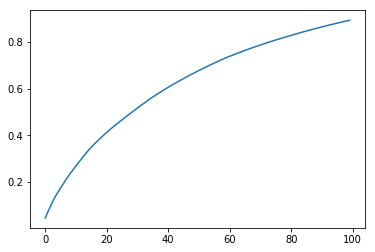

In [69]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.savefig('../output/pca_explained_variance_ratio.png', dpi=100, frameon=False,
            bbox_inches='tight', pad_inches=0.5, facecolor='#F2F2F2')

In [70]:
pipe = Pipeline([
    ('logreg', LogisticRegression(max_iter=1000))
])

params = {'logreg__C': [1, .5, .1]}

ts_split = TimeSeriesSplit(n_splits=3).split(X_train)

gs_pca_over = GridSearchCV(pipe ,params, scoring='roc_auc', cv = ts_split)

gs_pca_over.fit(X_train_pca, y_train_over)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000264125CCC78>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logreg__C': [1, 0.5, 0.1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [71]:
gs_pca_over.score(X_train_pca, y_train_over)

0.5567941808513113

In [72]:
gs_pca_over.score(X_test_pca, y_test_over)

0.5042664977456497

In [73]:
pipe = Pipeline([
    ('logreg', LogisticRegression(max_iter=1000))
])

params = {'logreg__C': [1, .5, .1]}

ts_split = TimeSeriesSplit(n_splits=3).split(X_train)

gs_pca_under = GridSearchCV(pipe ,params, scoring='roc_auc', cv = ts_split)

gs_pca_under.fit(X_train_pca, y_train_under)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002641A0258B8>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logreg__C': [1, 0.5, 0.1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [74]:
gs_pca_under.score(X_train_pca, y_train_under)

0.5556719216707923

In [75]:
gs_pca_under.score(X_test_pca, y_test_under)

0.5082792881787856

I chose a large number of components to perform Principal Component Analysis with, based on the number of features I had in my dataset. PCA did not perform much better, in terms of adding measuable variability to my model.

## SelectFromModel

In [76]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('frommodel', SelectFromModel(LogisticRegression(penalty='l1'))),
    ('logreg', LogisticRegression(max_iter=1000))
])

params = {'logreg__C': [1, .5, .1]}

ts_split = TimeSeriesSplit(n_splits=3).split(X_train)

gs_from_model = GridSearchCV(pipe ,params, scoring='roc_auc', cv = ts_split)

gs_from_model.fit(X_train, y_train_over)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converte

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by St

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000264125CCC00>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('frommodel', SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_s...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logreg__C': [1, 0.5, 0.1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [77]:
gs_from_model.score(X_train, y_train_over)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.584315612145026

In [78]:
gs_from_model.score(X_test, y_test_over)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.5219544773146144

In [79]:
pred_probas_over_fm = gs_from_model.predict_proba(X_test)
fm_bet_over = [x[1] > .62 for x in pred_probas_over_fm]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [80]:
y_test_over[fm_bet_over].sum()

42

In [81]:
y_test_over[fm_bet_over].mean()

0.6

In [82]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('frommodel', SelectFromModel(LogisticRegression(penalty='l1'))),
    ('logreg', LogisticRegression(max_iter=1000))
])

params = {'logreg__C': [1, .5, .1]}

ts_split = TimeSeriesSplit(n_splits=3).split(X_train)

gs_from_model_under = GridSearchCV(pipe ,params, scoring='roc_auc', cv = ts_split)

gs_from_model_under.fit(X_train, y_train_under)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converte

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by St

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002641A0259A8>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('frommodel', SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_s...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logreg__C': [1, 0.5, 0.1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [83]:
gs_from_model_under.score(X_train, y_train_under)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.5838614602939277

In [84]:
gs_from_model_under.score(X_test, y_test_under)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.5299488897478847

In [85]:
pred_probas_under_fm = gs_from_model_under.predict_proba(X_test)
fm_bet_under = [x[1] > .62 for x in pred_probas_under_fm]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [86]:
y_test_under[fm_bet_under].sum()

52

In [87]:
y_test_under[fm_bet_under].mean()

0.5416666666666666

In [88]:
under_thresh_dict = {}
under_winnings_dict = {}

for thresh in np.linspace(.5, .66, 16):
    under_thresh_dict[thresh] = sum([x[1] > thresh for x in pred_probas_under_fm])
    under_winnings_dict[thresh] = np.mean(y_test_under[[x[1] > thresh for x in pred_probas_under_fm]])


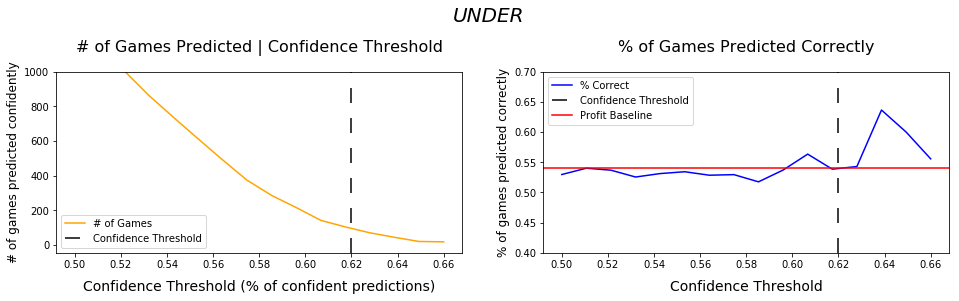

In [89]:
dashes = [10,10]

fig = plt.figure(figsize=(16,9))
fig.subplots_adjust(hspace=.7)

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

ax1.plot(under_thresh_dict.keys(), under_thresh_dict.values(), c='orange')
ax1.axvline(0.62, dashes=dashes, c='black')
ax1.set_xlabel("Confidence Threshold (% of confident predictions)", fontsize=14, labelpad=10)
ax1.set_ylim(top=1000)
ax1.set_ylabel('# of games predicted confidently', fontsize=12)
ax1.set_title("# of Games Predicted | Confidence Threshold", fontsize=16, y=1.08)
ax1.legend(['# of Games', 'Confidence Threshold'])


ax2.plot(under_winnings_dict.keys(), under_winnings_dict.values(), c='b')
ax2.axvline(0.62, dashes=dashes, c='black')
ax2.axhline(0.54, c='red')
ax2.set_xlabel("Confidence Threshold", fontsize=14, labelpad=10)
ax2.set_ylim(bottom=0.40, top=0.70)
ax2.set_ylabel('% of games predicted correctly', fontsize=12)
ax2.set_title("% of Games Predicted Correctly", fontsize=16, y=1.08)
ax2.legend(['% Correct', 'Confidence Threshold', 'Profit Baseline'])


fig.suptitle("UNDER", fontsize=20, fontstyle='oblique')
plt.savefig('../output/predictions_confidence_threshold_under.png', dpi=100, frameon=False,
            bbox_inches='tight', pad_inches=0.5, facecolor='#F2F2F2')



The above graph shows the results of my model predicting unders for a season of NBA games. The confidence threshold represents the level above which I will term a prediction "confident;" if my model assigns a probabilty of an NBA game being under above the threshold I set, I will label this prediction confident. The graph on the left shows how the higher the level at which a prediction is deemed confident, the fewer games are able to be predicted "confidently." At the same time, the higher the level of the confidence threshold, the more correct the predictions are, taken as an average. 

As the confidence threshold increases, the number of games the model predicts confidently decreases, while the accuracy of those predictions increases. The challenge becomes finding a threshold that will return a majority of correct predictions, while also maximizing the number of games the model predicts confidently. The goal is to have an average of above 54% of predictions being correct. (54% because the average of games which are under the point total is 49%, and there is typically a 5% "vig" on every bet, the amount the bookkeeper charges for accepting the bet.)

The below sum is the # of games my under model predicted "confidently"

In [90]:
y_test_under[fm_bet_under].sum()

52

And the below mean is the mean of the confident under predictions the model made which were correct.

In [91]:
y_test_under[fm_bet_under].mean()

0.5416666666666666

My "UNDER" model performed better than the baseline in predicting whether a game would be under, but not well enough to return a profit.

In [92]:
over_thresh_dict = {}
over_winnings_dict = {}

for thresh in np.linspace(.5, .66, 16):
    over_thresh_dict[thresh] = sum([x[1] > thresh for x in pred_probas_over_fm])
    over_winnings_dict[thresh] = np.mean(y_test_over[[x[1] > thresh for x in pred_probas_over_fm]])


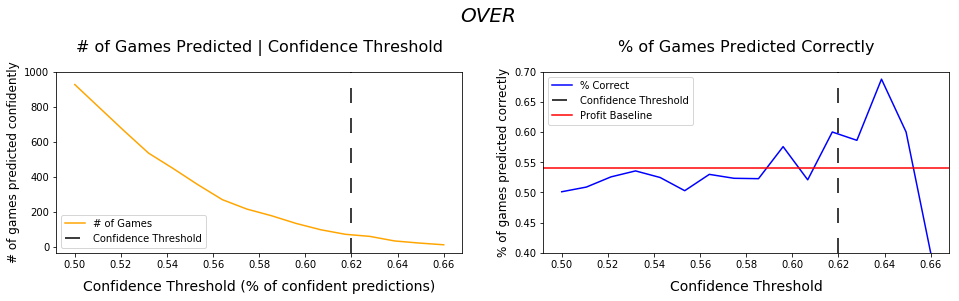

In [93]:
dashes = [10,10]

fig = plt.figure(figsize=(16,9))
fig.subplots_adjust(hspace=.7)

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

ax1.plot(over_thresh_dict.keys(), over_thresh_dict.values(), c='orange')
ax1.axvline(0.62, dashes=dashes, c='black')
ax1.set_xlabel("Confidence Threshold (% of confident predictions)", fontsize=14, labelpad=10)
ax1.set_ylim(top=1000)
ax1.set_ylabel('# of games predicted confidently', fontsize=12)
ax1.set_title("# of Games Predicted | Confidence Threshold", fontsize=16, y=1.08)
ax1.legend(['# of Games', 'Confidence Threshold'])


ax2.plot(over_winnings_dict.keys(), over_winnings_dict.values(), c='b')
ax2.axvline(0.62, dashes=dashes, c='black')
ax2.axhline(0.54, c='red')
ax2.set_xlabel("Confidence Threshold", fontsize=14, labelpad=10)
ax2.set_ylim(bottom=0.40, top=0.70)
ax2.set_ylabel('% of games predicted correctly', fontsize=12)
ax2.set_title("% of Games Predicted Correctly", fontsize=16, y=1.08)
ax2.legend(['% Correct', 'Confidence Threshold', 'Profit Baseline'])


fig.suptitle("OVER", fontsize=20, fontstyle='oblique')

plt.savefig('../output/predictions_confidence_threshold_over.png', dpi=100, frameon=False,
            bbox_inches='tight', pad_inches=0.5, facecolor='#F2F2F2')


The above graph shows the results of my model predicting overs for a season of NBA games. As with the graphs showing the results of my "UNDER" model, as the confidence threshold rises, the # of games the model confidently predicts as over shrinks, while the correctness of those predictions increases.  

The below sum is the # of games my under model predicted "confidently"

In [94]:
y_test_over[fm_bet_over].sum()

42

And the below mean is the mean of the confident over predictions the model made which were correct.

In [95]:
y_test_over[fm_bet_over].mean()

0.6

My "OVER" model performed better than the baseline in predicting whether a game would be under, and well enough to return a profit.

In [96]:
selectfromcols = X_train.columns[gs_from_model_under.best_estimator_.named_steps['frommodel'].get_support()]

selectfrom_coef = gs_from_model_under.best_estimator_.named_steps['logreg'].coef_

pd.DataFrame(selectfrom_coef, columns=selectfromcols).T.sort_values(0, ascending=False).head(10)

,0
ft_1_3_opp,0.191876
ft_1_3,0.191876
fga_1_1,0.187469
fga_1_1_opp,0.187469
fg%_1_1_opp,0.169260
fg%_1_1,0.169260
off_rating_2_1,0.157708
off_rating_2_1_opp,0.157708
fg%_2_2_opp,0.156539
fg%_2_2,0.156539


In [97]:
pd.DataFrame(selectfrom_coef, columns=selectfromcols).T.sort_values(0, ascending=False).tail(10)

,0
fg_1_1_opp,-0.131063
fg_1_1,-0.131063
fta_2_3,-0.155143
fta_2_3_opp,-0.155143
game_total_score_1_opp,-0.159000
game_total_score_1,-0.159000
pts_2_1_opp,-0.178321
pts_2_1,-0.178321
fta_1_3_opp,-0.219720
fta_1_3,-0.219720


In [98]:
len(selectfromcols)

225

My final model has 228 features

### Modeling Conclusions

In [99]:
sum(fm_bet_under)

96

In [100]:
sum(fm_bet_over)

70

In [101]:
fm_confident_under = y_test_under[fm_bet_under]

In [102]:
fm_confident_over = y_test_over[fm_bet_over]

In [103]:
fm_confident_over = fm_confident_over.rename('bet_won_over_pred')

In [104]:
fm_confident_under = fm_confident_under.rename('bet_won_under_pred')

In [105]:
games_to_bet = pd.concat([y_test_over, y_test_under], axis=1)

In [106]:
games_to_bet['bet_over'] = list(map(int, fm_bet_over))
games_to_bet['bet_under'] = list(map(int, fm_bet_under))

In [107]:
games_to_bet['bet_either'] = list((games_to_bet['bet_over']==1) | (games_to_bet['bet_under']==1))

In [108]:
games_to_bet.drop(labels=[x for x in games_to_bet.index if x%2], inplace=True)

In [109]:
games_to_bet.head()

,bet_won_over,bet_won_under,bet_over,bet_under,bet_either
1262,0,1,0,0,False
1266,0,1,1,0,True
1270,0,1,0,0,False
1274,1,0,0,0,False
1278,1,0,0,0,False


In [110]:
bets = games_to_bet[games_to_bet['bet_either'] == 1].copy()

In [111]:
bets.drop('bet_either', 1, inplace=True)

In [112]:
betting_sets = bets.to_records(index=False)

### Simulation

Below is a simulation I created to test how well someone could do if they bet a fixed amount of money (200 dollars) on every game where I predicted a "confident" outcome. These bets return 190 if they hit (bookkeapers typically return 100 dollars for a bet of 105). So, for every game with a confident prediction, you win 190 dollars for a correct prediction, and lose 200 dollars for an incorrect prediction.

In [113]:
pot = 10000
running_total = []
for game in betting_sets:
    if game[2] and game[0]:
        pot += 190
    if game[2] and not game[0]:
        pot -= 200
    if game[3] and game[1]:
        pot += 190
    if game[3] and not game[1]:
        pot -= 200
    if pot <= 0:
        break
    running_total.append(pot)
print(pot)

11730


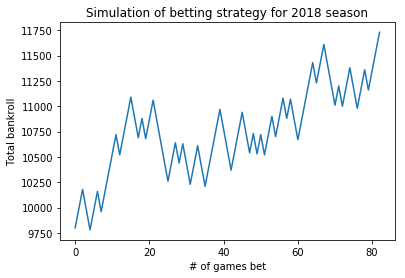

In [114]:
plt.plot(running_total)
plt.title('Simulation of betting strategy for 2018 season')
plt.ylabel('Total bankroll')
plt.xlabel('# of games bet')
plt.savefig('../output/betting_strategy_simulation_2018.png', dpi=100, frameon=False,
            bbox_inches='tight', pad_inches=0.5, facecolor='#F2F2F2')

In [115]:
games_to_bet[games_to_bet.bet_either == True].describe()

,bet_won_over,bet_won_under,bet_over,bet_under
count,83.000000,83.000000,83.000000,83.000000
mean,0.518072,0.469880,0.421687,0.578313
std,0.502711,0.502126,0.496831,0.496831
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [116]:
print("System and module version information:")
print("\n")
print(f'Python version: {sys.version_info}')
print(f'numpy version: {np.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'seaborn version: {sns.__version__}')
print(f'matplotlib version: {matplotlib.__version__}')
print(f'last updated: {datetime.now().strftime("%Y-%m-%d %H:%M")}')

System and module version information:


Python version: sys.version_info(major=3, minor=7, micro=1, releaselevel='final', serial=0)
numpy version: 1.15.4
pandas version: 0.23.4
seaborn version: 0.9.0
matplotlib version: 3.0.2
last updated: 2019-12-05 21:06
